In [2]:
#Making a Hybrid Fourier Transform Model (Imbued with Time Series & Machine Learning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, entropy
from numpy.fft import fft, fftfreq
import seaborn as sns
import ta

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import(
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import glob
from pandas.tseries.offsets import BDay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

#for data saving
import joblib

In [4]:
data = pd.read_csv("StockData.csv")
data["Date"] = pd.to_datetime(data["Date"])
data.sort_values(by=['Ticker', 'Date'], inplace=True)

In [ ]:
print(data)

            Date Ticker       Open       High        Low      Close  \
53949 2015-01-05   AAPL  27.072500  27.162500  26.352501  26.562500   
53950 2015-01-06   AAPL  26.635000  26.857500  26.157499  26.565001   
53951 2015-01-07   AAPL  26.799999  27.049999  26.674999  26.937500   
53952 2015-01-08   AAPL  27.307501  28.037500  27.174999  27.972500   
53953 2015-01-09   AAPL  28.167500  28.312500  27.552500  28.002501   
...          ...    ...        ...        ...        ...        ...   
69358 2025-03-17     MG   9.910000  10.120000   9.870000   9.880000   
69359 2025-03-18     MG   9.700000   9.940000   9.640000   9.870000   
69360 2025-03-19     MG   9.880000  10.130000   9.870000  10.070000   
69361 2025-03-20     MG   9.990000  10.100000   9.780000  10.010000   
69362 2025-03-21     MG  10.110000  10.820000  10.100000  10.580000   

        Adjusted   Returns     Volume  
53949  23.635283 -0.028172  257142000  
53950  23.637512  0.000094  263188400  
53951  23.968964  0.014022 

In [ ]:
#Checking if there is Null Values
data.isnull().sum()

,0
Date,0
Ticker,0
Open,0
High,0
Low,0
Close,0
Adjusted,0
Returns,0
Volume,0


In [ ]:
#doing descriptive statistics
data.describe()

,Open,High,Low,Close,Adjusted,Returns,Volume
count,71932.000000,71932.000000,71932.000000,71932.000000,71932.000000,71932.000000,7.193200e+04
mean,115.739938,116.875792,114.584569,115.746334,105.425129,0.000538,1.301553e+07
std,99.982148,100.889323,99.050998,99.980152,95.986432,0.020335,2.754006e+07
min,2.980000,3.250000,2.770000,2.910000,2.910000,-0.327052,3.200000e+03
25%,44.040001,44.535984,43.580002,44.045468,37.107365,-0.007844,2.360433e+06
50%,89.440002,90.470001,88.286049,89.360767,76.358276,0.000575,4.826680e+06
75%,155.322506,156.860001,153.852505,155.350006,143.398621,0.008998,1.161832e+07
max,669.080017,672.190002,663.280029,672.190002,668.873291,0.376669,6.488252e+08


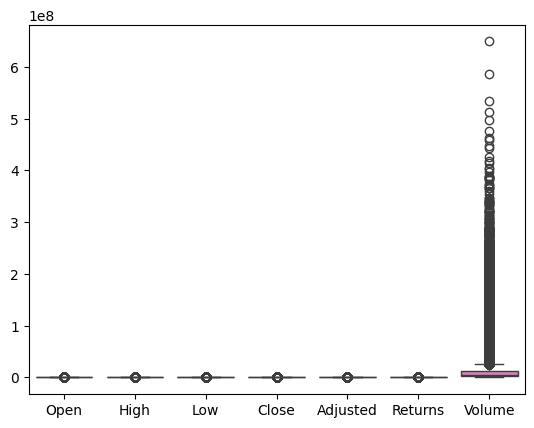

In [ ]:
#Checking for outliers
sns.boxplot(data=data)
plt.savefig("Outliers.png")
plt.show()

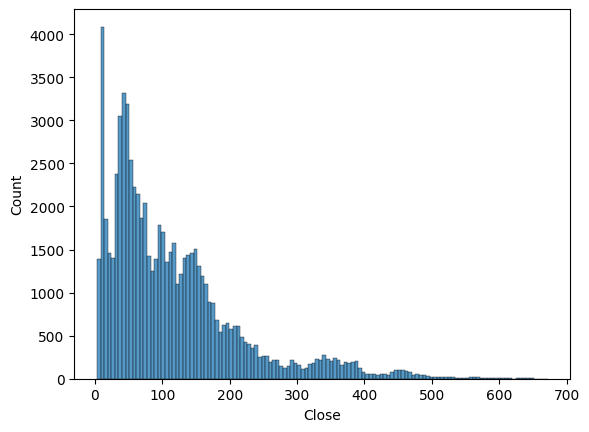

In [ ]:
#Checking for Price Distribution
sns.histplot(data["Close"])
plt.savefig("Price Distribution.png")
plt.show()

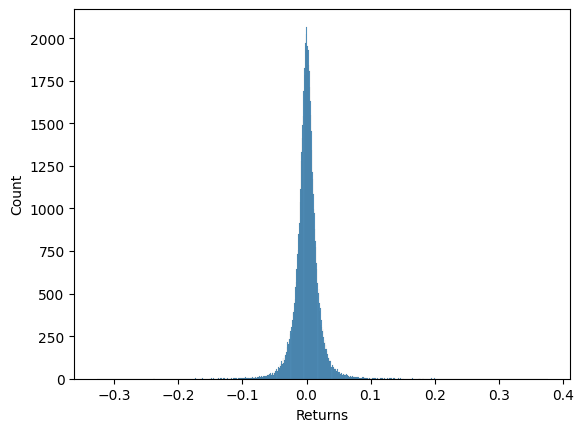

In [ ]:
#Checking for price imbalances
sns.histplot(data["Returns"])
plt.savefig("Price Imbalance.png")
plt.show()

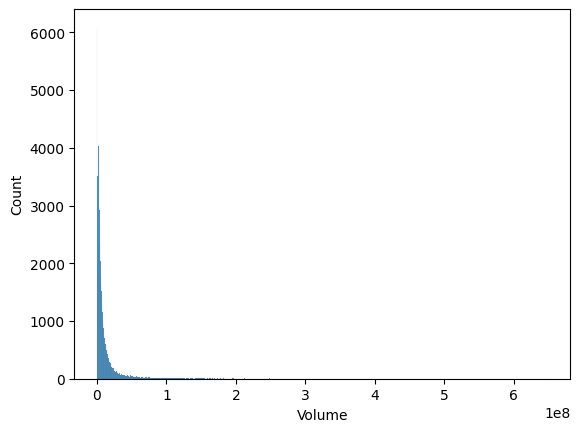

In [ ]:
#Checking for Volumne Analysis
sns.histplot(data["Volume"])
plt.savefig("Volume Analysis.png")
plt.show()

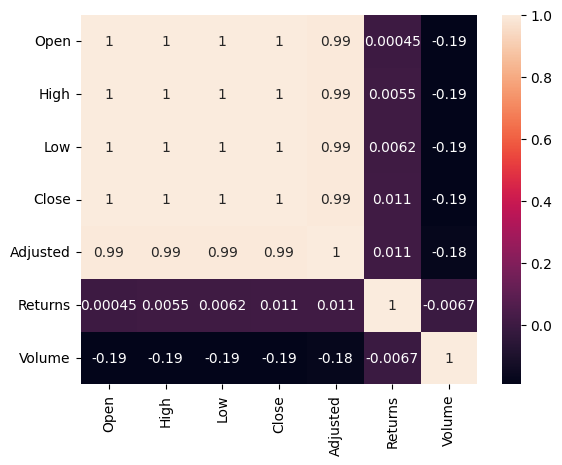

In [ ]:
#Checking for Correlation Analysis
# Filter numeric columns only
numeric_data = data.select_dtypes(include='number')

# Now plot correlation heatmap
sns.heatmap(numeric_data.corr(), annot=True)
plt.savefig("Correlation Analysis.png")
plt.show()

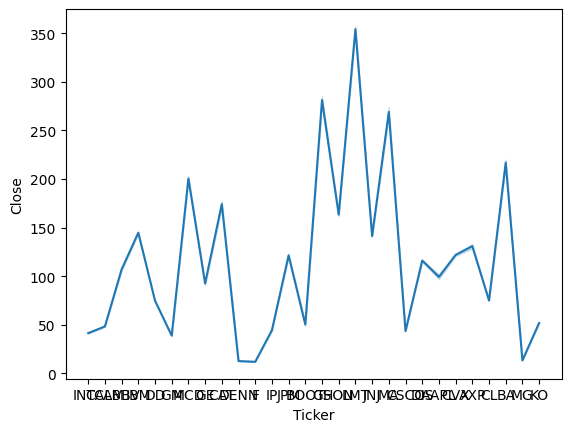

In [ ]:
#Plotting and Showing the most dominant ticker
sns.lineplot(data=data, x="Ticker", y="Close")
plt.savefig("Most Dominant Ticker.png")
plt.show()


In [5]:
# Create returns and target
data['Returns'] = data.groupby('Ticker')['Adjusted'].pct_change()
data['Target'] = data.groupby('Ticker')['Returns'].shift(-1)

# FFT Features
fft_features = []
tickers = data['Ticker'].unique()
window_size = 64
top_n = 3

for ticker in tickers:
    df_t = data[data['Ticker'] == ticker].copy()
    df_t = df_t.sort_values('Date')
    for i in range(window_size, len(df_t)):
        window = df_t['Adjusted'].iloc[i - window_size:i].values
        fft_vals = np.fft.fft(window)
        fft_freqs = np.fft.fftfreq(len(window))
        amps = np.abs(fft_vals)
        pos_mask = fft_freqs > 0
        freqs = fft_freqs[pos_mask]
        amps = amps[pos_mask]
        top_indices = np.argsort(amps)[-top_n:]
        row = {
            'Date': df_t.iloc[i]['Date'],
            'Ticker': ticker,
            'fft_amp_1': amps[top_indices[0]],
            'fft_amp_2': amps[top_indices[1]],
            'fft_amp_3': amps[top_indices[2]],
            'fft_dom_freq': freqs[np.argmax(amps)]
        }
        fft_features.append(row)

fft_df = pd.DataFrame(fft_features)
data = data.merge(fft_df, on=['Date', 'Ticker'], how='left')

# Rolling features
for window in [5, 10, 20]:
    data[f'rolling_mean_{window}'] = data.groupby('Ticker')['Adjusted'].transform(lambda x: x.rolling(window).mean())
    data[f'rolling_std_{window}'] = data.groupby('Ticker')['Adjusted'].transform(lambda x: x.rolling(window).std())
    data[f'volatility_{window}'] = data.groupby('Ticker')['Returns'].transform(lambda x: x.rolling(window).std())
    data[f'return_lag_{window}'] = data.groupby('Ticker')['Returns'].shift(window)
    data[f'zscore_vol_{window}'] = (
        (data[f'volatility_{window}'] - data.groupby('Ticker')[f'volatility_{window}'].transform(lambda x: x.rolling(window).mean()))
        / (data.groupby('Ticker')[f'volatility_{window}'].transform(lambda x: x.rolling(window).std()) + 1e-6)
    )

# Volume & price
data['VWAP'] = (data['Volume'] * (data['High'] + data['Low']) / 2) / data['Volume']
data['LogVolume'] = np.log1p(data['Volume'])
data['Volume_Change'] = data.groupby('Ticker')['Volume'].pct_change()
data['DollarVolume'] = data['Volume'] * data['Adjusted']
data['AvgDollarVolume_10'] = data.groupby('Ticker')['DollarVolume'].transform(lambda x: x.rolling(10).mean())

# Drawdown
data['RollingDrawdown_10'] = data.groupby('Ticker')['Adjusted'].transform(
    lambda x: x.rolling(10).apply(lambda p: np.min((p - np.maximum.accumulate(p)) / np.maximum.accumulate(p)), raw=True)
)

# Trend Slope
data['TrendSlope_10'] = data.groupby('Ticker')['Adjusted'].transform(
    lambda x: x.rolling(10).apply(lambda s: np.polyfit(np.arange(len(s)), np.log1p(s), 1)[0] if s.notna().all() else np.nan)
)

# Rolling return and yield proxy
data['RollingReturn_10'] = data.groupby('Ticker')['Adjusted'].transform(lambda x: x.pct_change(10))
data['Yield_Proxy'] = data['RollingReturn_10'] / (data['rolling_std_10'] + 1e-6)

# Skew and kurtosis
data['Skew_10'] = data.groupby('Ticker')['Returns'].transform(lambda x: x.rolling(10).skew())
data['Kurt_10'] = data.groupby('Ticker')['Returns'].transform(lambda x: x.rolling(10).kurt())

# Volatility ratio
data['VolatilityRatio_10_5'] = data['volatility_10'] / (data['volatility_5'] + 1e-6)

# Rel to high/low
data['RelToHigh_10'] = data['Adjusted'] / data.groupby('Ticker')['High'].transform(lambda x: x.rolling(10).max())
data['RelToLow_10'] = data['Adjusted'] / data.groupby('Ticker')['Low'].transform(lambda x: x.rolling(10).min())

# Hurst exponent
data['Hurst_20'] = data.groupby('Ticker')['Adjusted'].transform(
    lambda x: x.rolling(20).apply(
        lambda s: np.polyfit(np.log(range(2, 20)),
                             np.log([np.std(s[lag:] - s[:-lag]) for lag in range(2, 20)]), 1)[0]
        if len(s.dropna()) == 20 else np.nan
    )
)

# Entropy
data['Entropy_10'] = data.groupby('Ticker')['Returns'].transform(
    lambda x: x.rolling(10).apply(lambda r: entropy(np.histogram(r.dropna(), bins=10)[0] + 1e-8))
)

# Autocorrelation
data['Autocorr_10'] = data.groupby('Ticker')['Returns'].transform(
    lambda x: x.rolling(10).apply(lambda s: s.autocorr(1))
)
data.fillna(0, inplace=True)


In [55]:
# Step 1: Setup X, y, and groups
X = data.drop(columns=["Target"])
y = data['Target']
if not isinstance(X.index, pd.MultiIndex) or X.index.names != ['Date', 'Ticker']:
    X = X.reset_index().set_index(['Date', 'Ticker'])
groups = X.index.get_level_values('Ticker')

if 'index' in X.columns:
    X = X.drop(columns=['index'])

# Step 2: TimeSeriesSplit (instead of train_test_split)
# We manually take the last split as test
tscv = TimeSeriesSplit(n_splits=5)

# Take the last split manually
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_train, groups_test = groups[train_idx], groups[test_idx]

# Step 3: Build the full pipeline (same structure, new model)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=200, min_samples_split=5, max_depth=10, random_state=42))
])

# Step 4: Fit the full pipeline on raw X_train
pipe.fit(X_train, y_train)

# Step 5: Predict using raw X_test (pipeline handles everything)
y_pred = pipe.predict(X_test)

In [58]:
pipe.feature_names_in_

array(['level_0', 'Open', 'High', 'Low', 'Close', 'Adjusted', 'Returns',
       'Volume', 'fft_amp_1', 'fft_amp_2', 'fft_amp_3', 'fft_dom_freq',
       'rolling_mean_5', 'rolling_std_5', 'volatility_5', 'return_lag_5',
       'zscore_vol_5', 'rolling_mean_10', 'rolling_std_10',
       'volatility_10', 'return_lag_10', 'zscore_vol_10',
       'rolling_mean_20', 'rolling_std_20', 'volatility_20',
       'return_lag_20', 'zscore_vol_20', 'VWAP', 'LogVolume',
       'Volume_Change', 'DollarVolume', 'AvgDollarVolume_10',
       'RollingDrawdown_10', 'TrendSlope_10', 'RollingReturn_10',
       'Yield_Proxy', 'Skew_10', 'Kurt_10', 'VolatilityRatio_10_5',
       'RelToHigh_10', 'RelToLow_10', 'Hurst_20', 'Entropy_10',
       'Autocorr_10'], dtype=object)

In [48]:
#then we evaluate the model
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)

    # Core Metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # Directional Accuracy
    y_direction_true = np.sign(y_true)
    y_direction_pred = np.sign(y_pred)
    directional_accuracy = (y_direction_true == y_direction_pred).mean()

    excess_returns = y_pred - y_true.mean()
    sharpe_ratio = np.mean(excess_returns) / (np.std(excess_returns) + 1e-9)

    print("Evaluation Metrics:")
    print(f"R² Score:            {r2:.4f}")
    print(f"MAE:                 {mae:.6f}")
    print(f"RMSE:                {rmse:.6f}")
    print(f"Directional Accuracy:{directional_accuracy:.2%}")
    print(f"Sharpe Ratio:        {sharpe_ratio:.4f}")

    return {
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "directional_accuracy": directional_accuracy,
        "sharpe_ratio": sharpe_ratio
    }

Evaluation Metrics:
R² Score:            0.0234
MAE:                 0.011691
RMSE:                0.019550
Directional Accuracy:53.09%
Sharpe Ratio:        0.0084


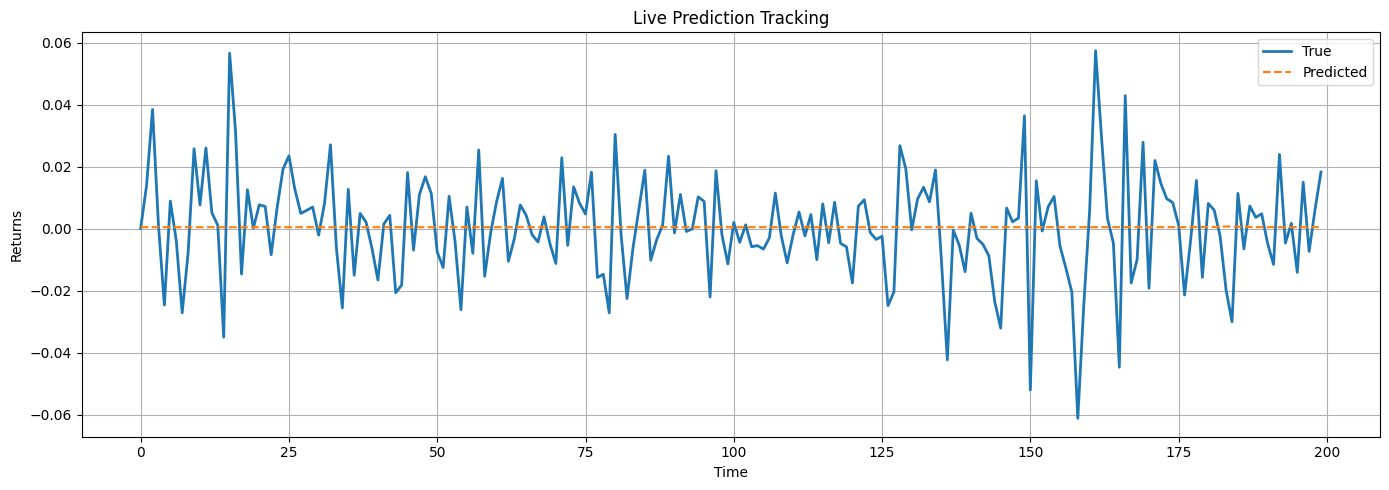

/tmp/ipython-input-61-1948276748.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


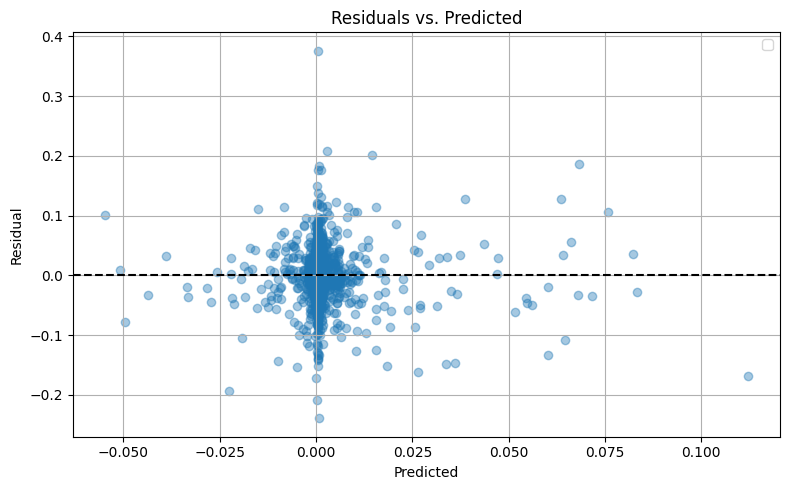

In [61]:
# Must use the original X_raw (with 'Date' and 'Ticker') used during training
metrics = evaluate_model(pipe, X_test, y_test)

#Plotting the predictions
n_points = 200

plt.figure(figsize=(14, 5))
plt.plot(y[:n_points].reset_index(drop=True), label='True', linewidth=2)
plt.plot(y_pred[:n_points], label='Predicted', linestyle='--')
plt.title("Live Prediction Tracking")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Live Prediction Tracking.png")
plt.show()

# Compute residuals
residuals = y_test - y_pred

# Residuals vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.savefig("Residuals vs Predicted.png")
plt.show()

In [50]:
#Tracking the pinball loss
# Evaluate quantile loss for multiple quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

print("📉 Quantile Losses:")
for q in quantiles:
    qloss = np.mean(np.maximum(q * residuals, (q - 1) * residuals))
    print(f"Quantile {q:.2f} Loss: {qloss:.6f}")

📉 Quantile Losses:
Quantile 0.10 Loss: 0.005859
Quantile 0.25 Loss: 0.005855
Quantile 0.50 Loss: 0.005847
Quantile 0.75 Loss: 0.005840
Quantile 0.90 Loss: 0.005836


In [74]:
# === Functions ===
def generate_features(df):
    df = df.copy()
    df['Returns'] = df.groupby('Ticker')['Adjusted'].pct_change()

    # FFT Features
    fft_features = []
    tickers = df['Ticker'].unique()
    window_size = 64
    top_n = 3

    for ticker in tickers:
        df_t = df[df['Ticker'] == ticker].copy().sort_values('Date')
        for i in range(window_size, len(df_t)):
            window = df_t['Adjusted'].iloc[i - window_size:i].values
            fft_vals = np.fft.fft(window)
            fft_freqs = np.fft.fftfreq(len(window))
            amps = np.abs(fft_vals)
            pos_mask = fft_freqs > 0
            freqs = fft_freqs[pos_mask]
            amps = amps[pos_mask]
            top_indices = np.argsort(amps)[-top_n:]
            row = {
                'Date': df_t.iloc[i]['Date'],
                'Ticker': ticker,
                'fft_amp_1': amps[top_indices[0]],
                'fft_amp_2': amps[top_indices[1]],
                'fft_amp_3': amps[top_indices[2]],
                'fft_dom_freq': freqs[np.argmax(amps)]
            }
            fft_features.append(row)

    fft_df = pd.DataFrame(fft_features)
    df = df.merge(fft_df, on=['Date', 'Ticker'], how='left')

    # Rolling features
    for window in [5, 10, 20]:
        df[f'rolling_mean_{window}'] = df.groupby('Ticker')['Adjusted'].transform(lambda x: x.rolling(window).mean())
        df[f'rolling_std_{window}'] = df.groupby('Ticker')['Adjusted'].transform(lambda x: x.rolling(window).std())
        df[f'volatility_{window}'] = df.groupby('Ticker')['Returns'].transform(lambda x: x.rolling(window).std())
        df[f'return_lag_{window}'] = df.groupby('Ticker')['Returns'].shift(window)
        df[f'zscore_vol_{window}'] = (
            (df[f'volatility_{window}'] - df.groupby('Ticker')[f'volatility_{window}'].transform(lambda x: x.rolling(window).mean()))
            / (df.groupby('Ticker')[f'volatility_{window}'].transform(lambda x: x.rolling(window).std()) + 1e-6)
        )

    df['VWAP'] = (df['Volume'] * (df['High'] + df['Low']) / 2) / df['Volume']
    df['LogVolume'] = np.log1p(df['Volume'])
    df['Volume_Change'] = df.groupby('Ticker')['Volume'].pct_change()
    df['DollarVolume'] = df['Volume'] * df['Adjusted']
    df['AvgDollarVolume_10'] = df.groupby('Ticker')['DollarVolume'].transform(lambda x: x.rolling(10).mean())
    df['RollingDrawdown_10'] = df.groupby('Ticker')['Adjusted'].transform(
        lambda x: x.rolling(10).apply(lambda p: np.min((p - np.maximum.accumulate(p)) / np.maximum.accumulate(p)), raw=True)
    )
    df['TrendSlope_10'] = df.groupby('Ticker')['Adjusted'].transform(
        lambda x: x.rolling(10).apply(lambda s: np.polyfit(np.arange(len(s)), np.log1p(s), 1)[0] if s.notna().all() else np.nan)
    )
    df['RollingReturn_10'] = df.groupby('Ticker')['Adjusted'].transform(lambda x: x.pct_change(10))
    df['Yield_Proxy'] = df['RollingReturn_10'] / (df['rolling_std_10'] + 1e-6)
    df['Skew_10'] = df.groupby('Ticker')['Returns'].transform(lambda x: x.rolling(10).skew())
    df['Kurt_10'] = df.groupby('Ticker')['Returns'].transform(lambda x: x.rolling(10).kurt())
    df['VolatilityRatio_10_5'] = df['volatility_10'] / (df['volatility_5'] + 1e-6)
    df['RelToHigh_10'] = df['Adjusted'] / df.groupby('Ticker')['High'].transform(lambda x: x.rolling(10).max())
    df['RelToLow_10'] = df['Adjusted'] / df.groupby('Ticker')['Low'].transform(lambda x: x.rolling(10).min())
    df['Hurst_20'] = df.groupby('Ticker')['Adjusted'].transform(
        lambda x: x.rolling(20).apply(
            lambda s: np.polyfit(np.log(range(2, 20)),
                                 np.log([np.std(s[lag:] - s[:-lag]) for lag in range(2, 20)]), 1)[0]
            if len(s.dropna()) == 20 else np.nan
        )
    )
    df['Entropy_10'] = df.groupby('Ticker')['Returns'].transform(
        lambda x: x.rolling(10).apply(lambda r: entropy(np.histogram(r.dropna(), bins=10)[0] + 1e-8))
    )
    df['Autocorr_10'] = df.groupby('Ticker')['Returns'].transform(
        lambda x: x.rolling(10).apply(lambda s: s.autocorr(1))
    )

    df.fillna(0, inplace=True)
    return df

# === Prediction + Submission ===
import glob
from pandas.tseries.offsets import BDay

test_files = sorted(glob.glob("test_*.csv"))
returns_forecast = {}

# Use exact Kaggle format dates — string format directly
forecast_dates = [
    '3/25/2025', '3/26/2025', '3/27/2025', '3/28/2025', '3/31/2025',
    '4/1/2025', '4/2/2025', '4/3/2025', '4/4/2025', '4/7/2025'
]

for i, filepath in enumerate(test_files, start=1):
    name = filepath.split('/')[-1]
    print(f"✅ Processing: {name}")

    try:
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df['Ticker'] = f'Test{i}'
        df["level_0"] = 0

        df = generate_features(df)

        X_input = df[pipe.feature_names_in_]
        last_row = X_input.iloc[-1:]
        preds = [pipe.predict(last_row)[0] for _ in range(10)]
        returns_forecast[f'Returns_{i}'] = preds

    except Exception as e:
        print(f"❌ Failed to process {name}: {e}")
        continue

# === Final Submission File ===
if not returns_forecast:
    raise ValueError("❌ No predictions made!")

submission_df = pd.DataFrame({'Date': forecast_dates})
for col, preds in returns_forecast.items():
    submission_df[col] = preds

# Final assertions and save
assert submission_df.shape == (10, 6), "❌ Must have 10 rows and 6 columns"
assert list(submission_df.columns) == ['Date', 'Returns_1', 'Returns_2', 'Returns_3', 'Returns_4', 'Returns_5'], "❌ Column names are wrong"
assert submission_df.isnull().sum().sum() == 0, "❌ Contains NaN values"

submission_df.to_csv("submission.csv", index=False)
print("✅ Submission saved to submission.csv")
print(submission_df)


✅ Processing: test_1.csv
✅ Processing: test_2.csv
✅ Processing: test_3.csv
✅ Processing: test_4.csv
✅ Processing: test_5.csv
✅ Submission saved to submission.csv
        Date  Returns_1  Returns_2  Returns_3  Returns_4  Returns_5
0  3/25/2025   0.000544   0.000466   0.000477   0.065349   0.000519
1  3/26/2025   0.000544   0.000466   0.000477   0.065349   0.000519
2  3/27/2025   0.000544   0.000466   0.000477   0.065349   0.000519
3  3/28/2025   0.000544   0.000466   0.000477   0.065349   0.000519
4  3/31/2025   0.000544   0.000466   0.000477   0.065349   0.000519
5   4/1/2025   0.000544   0.000466   0.000477   0.065349   0.000519
6   4/2/2025   0.000544   0.000466   0.000477   0.065349   0.000519
7   4/3/2025   0.000544   0.000466   0.000477   0.065349   0.000519
8   4/4/2025   0.000544   0.000466   0.000477   0.065349   0.000519
9   4/7/2025   0.000544   0.000466   0.000477   0.065349   0.000519
